<a href="https://colab.research.google.com/github/MarcoDVisser/GEEnotebooks/blob/main/EE_surfaceTemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temperature times series extraction in GEE 

In [ ]:
## load packages and authenticate
import ee
import folium
import pandas as pd

## authenticate and initialize  
## (initialize the API & grant this notebook access to Earth Engine using your account)
ee.Authenticate() ## uncomment if running for the first time

ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=kdo--cx0lJGXFG8hNWyHdxW_G5hdX6o6wf26h1zSmso&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 


KeyboardInterrupt: ignored

Next we check the [GEE catelog](https://developers.google.com/earth-engine/datasets/catalog) and search for the required product. In this case we are using the modis landsurface temperature and modis landcover datasets. We also load in the Shuttle randar altermetry data. A useful feature of GEE is that it handles projections automatically - you rarely have to worry about it. 

In [ ]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

We can either look it up in the catelog or extract information from the images directyly.

Next we can filter the images to a disered date range. 

In [ ]:
## date of temperature
date = ee.Date(lst.first().get('system:time_start'))

date_dict = date.getInfo()

print("The number of milliseconds since 1970-01-01T00:00:00Z.: ", date_dict['value'])

print("Formatted date", date.format('Y-M-d').getInfo())

# Initial date of interest (inclusive).
i_date = date.format('Y-M-d').getInfo()

# Final date of interest (exclusive).
f_date = '2021-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

The number of milliseconds since 1970-01-01T00:00:00Z.:  951350400000
Formatted date 2000-2-24


Next lets subset this to a region of interest, in this case I will subset it into two parts: 1) the city of Leiden (52.158506,4.489852) and 2) a rural area nearby - Vrouwe Venne Polder (52.186458,4.555485) - and set these are EE geometry point objects

In [ ]:
# Define the urban location of interest 
u_lon = 4.489
u_lat = 52.159
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 4.555
r_lat = 52.186
r_poi = ee.Geometry.Point(r_lon, r_lat)

Next we can sample the data in the image collection (this may take a few seconds) - key function is "sample"

In [ ]:
scale = 1000  # scale in meters

# Print the elevation near Leiden.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

## same for rural point
# Print the elevation near Leiden.
elv_urban_point = elv.sample(r_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at rural point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(r_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at rural point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(r_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at rural point is:', lc_urban_point)

Ground elevation at urban point: 4 m
Average daytime LST at urban point: 18.42 °C
Land cover value at urban point is: 13
Ground elevation at rural point: -4 m
Average daytime LST at rural point: 15.02 °C
Land cover value at rural point is: 9


## Lets build a map using folium to explore the data visually.


In [ ]:
## first we build the add layer function for folium 
## New method to display the image tiles
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
## date of landcover
lcdate = ee.Date(lc.first().get('system:time_start'))

# Initial date of interest (inclusive).
lci_date = lcdate.format('Y-M-d').getInfo()

# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(lci_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Define the center of our map.
lat, lon = 52.2, 5.555
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())


Next we can add additional layers, and then save the map as a html file which we can open in a browser later.

In [29]:
## next we can extract the surface temperature image and the elevation img
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

## this clips the map to the Netherlands so it loads faster

# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
NL = countries.filter(ee.Filter.eq('ADM0_NAME', 'Netherlands'))

# Clip the image 
elv = elv.clip(NL)
lst_img = lst_img.clip(NL)
lc_img = lc_img.clip(NL)

# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

# time series in GEE
Next lets extarct and plot the time series. Key function is "getRegion" 

In [ ]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2000_02_24', 4.48708484417701, 52.16067697240002, 951350400000, None, 2],
 ['2000_02_25', 4.48708484417701, 52.16067697240002, 951436800000, None, 2],
 ['2000_02_26', 4.48708484417701, 52.16067697240002, 951523200000, None, 2],
 ['2000_02_27', 4.48708484417701, 52.16067697240002, 951609600000, None, 2]]

The above colum shows the information in the dataset (QC_Day = quality control. Next we migrate this dataset to a pandas dataframe which is easier to manipulate 

In [ ]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

###########################################################################
## Now apply it to the 2 poi

lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
8,952041600000,2000-03-03,10.45
9,952128000000,2000-03-04,1.83
16,952732800000,2000-03-11,13.05
24,953424000000,2000-03-19,12.45
25,953510400000,2000-03-20,10.05


Now that we have our data in a good shape, we can easily make plots and compare the trends. We expect that LST has a seasonality influence and the sinusoidal trend described by [Stallman (1965)](https://doi.org/10.1029/JZ070i012p02821) reading as follow:

$$
LST(t) = LST_{0} + \frac{\Delta _{LST}}{2}sin(\frac{2\pi t}{\tau} + \phi)
$$

where:

- $LST_{0}$ represents the mean annual LST,
- $\Delta _{LST}$ represents the amplitude between maximal and minimal LST,
- $\tau$ represents the period of oscillation of LST, and
- $\phi$ represents an offset needed to adjust the time when $LST(t) = LST_{0}$

Consequently, on the top of the data scatter plot, we plot the fitting curve using the scipy library:

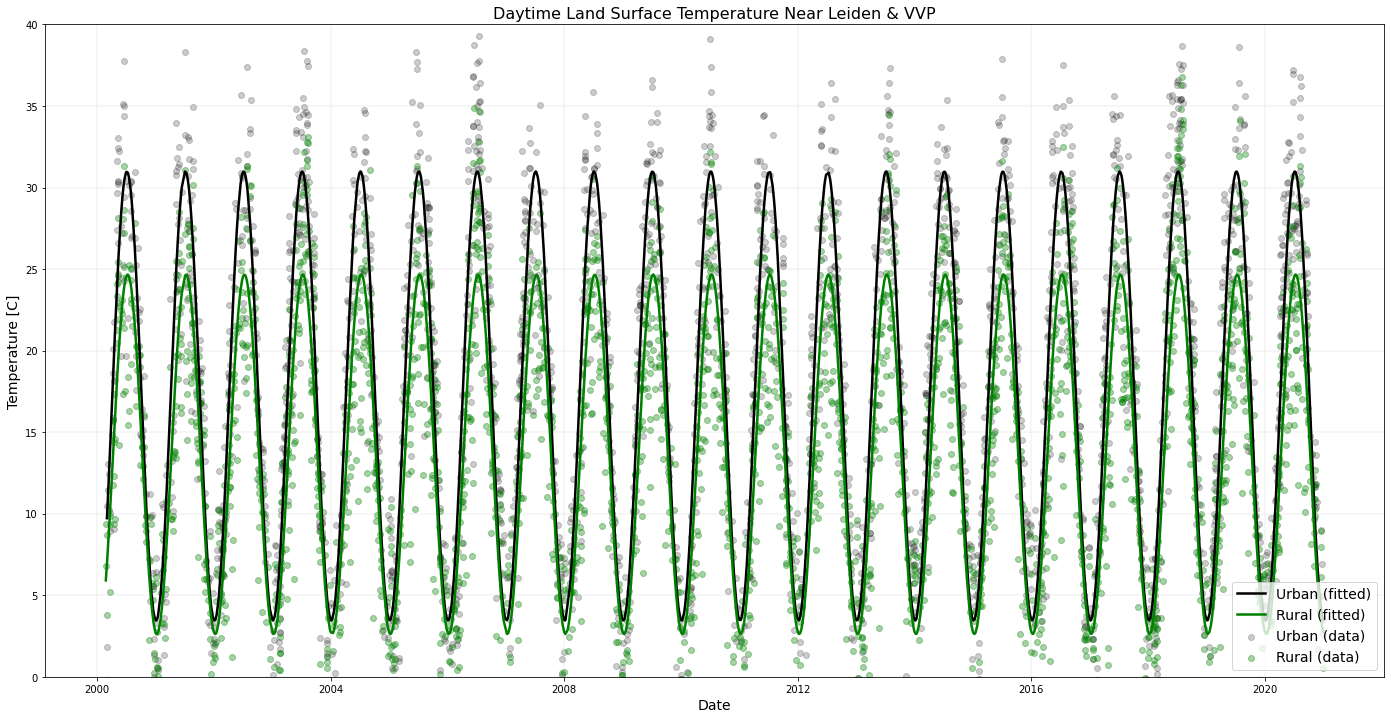

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(24, 12))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Leiden & VVP', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()